In [1]:
import pandas as pd
import numpy as np

from myadaboost import MyAdaBoost
from math import exp

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import time

## Cross Validation
#### Parameters:
*   K = 5
*   T = 35
*   N = 1000



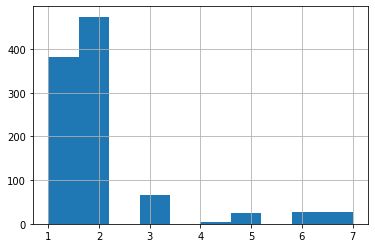

In [18]:
K = 5
k_fold = KFold(n_splits=K)
T = 35

n_classes = 7
model = MyAdaBoost(T, [1,2,3,4,5,6,7], save_statistics=True)

df = pd.read_csv('covtype.csv', sep=',',header=0)
df = df.sample(n=1000, random_state=38).reset_index(drop=True)

df.Cover_Type.hist()

cv_train_full = []
cv_train_classes = [[],[],[],[],[],[],[]]
cv_test_full = []
cv_test_classes = [[],[],[],[],[],[],[]]

In [19]:
# Cross Validation, taking values at each round for every fold.

for train, test in k_fold.split(df):
    
    start = time.time()
    model.fit(df.loc[train])
    print(f"fit in time {time.time()-start} / {(time.time()-start)/T} single round")

    start = time.time()
    errors_rounds = [model.error(df.loc[test], t, True) for t in range(1, T+1)]
    cv_test_full.append([full_error for full_error,_ in errors_rounds])

    for i in range(n_classes):
        cv_test_classes[i].append([class_error[i] for _,class_error in errors_rounds])
    
    errors_rounds = [model.error(df.loc[train], t, True) for t in range(1, T+1)]
    cv_train_full.append([full_error for full_error,_ in errors_rounds])

    for i in range(n_classes):
        cv_train_classes[i].append([class_error[i] for _,class_error in errors_rounds])

    print(f"computed errors in {time.time()-start}")

print(f"train\n{cv_train_full}\n" +
      f"test\n{cv_test_full}\n")

fit in time 33.31976556777954 / 0.9519936629704067 single round
computed errors in 2.5788638591766357
fit in time 33.176581621170044 / 0.9479026998792376 single round
computed errors in 2.5613901615142822
fit in time 33.17115092277527 / 0.9477475302559989 single round
computed errors in 2.5955445766448975
fit in time 33.22433638572693 / 0.949267087663923 single round
computed errors in 2.6443002223968506
fit in time 33.17182278633118 / 0.9477667127336774 single round
computed errors in 2.581575632095337
train
[[0.34625, 0.34625, 0.425, 0.35875, 0.37625, 0.3575, 0.36125, 0.33625, 0.34375, 0.3325, 0.34375, 0.33125, 0.33375, 0.3425, 0.34125, 0.3375, 0.34375, 0.34625, 0.3375, 0.34875, 0.33875, 0.34625, 0.3475, 0.3425, 0.34375, 0.345, 0.34, 0.34125, 0.34, 0.34375, 0.34375, 0.33875, 0.3375, 0.33125, 0.3325], [0.3375, 0.3375, 0.385, 0.355, 0.37375, 0.375, 0.35, 0.35875, 0.35625, 0.36, 0.33125, 0.35, 0.34375, 0.35375, 0.33625, 0.3525, 0.335, 0.345, 0.33375, 0.3425, 0.33, 0.33875, 0.3275, 0.338

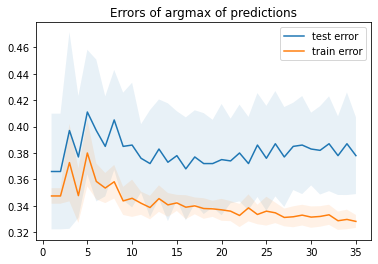

In [20]:
# plot of test and train errors on the multiclassification at each round.

fig, ax = plt.subplots()

epochs = range(1, T+1)

mean_test_error = np.mean(cv_test_full, axis=0)
std_test_error = np.std(cv_test_full, axis=0)

ax.plot(epochs, mean_test_error, label = "test error")
ax.fill_between(epochs, mean_test_error-std_test_error, mean_test_error+std_test_error ,alpha=0.1)

mean_train_error = np.mean(cv_train_full, axis=0)
std_train_error = np.std(cv_train_full, axis=0)

ax.plot(epochs, mean_train_error, label = "train error")
ax.fill_between(epochs, mean_train_error-std_train_error, mean_train_error+std_train_error ,alpha=0.1)

plt.title('Errors of argmax of predictions')
plt.legend()
plt.show()

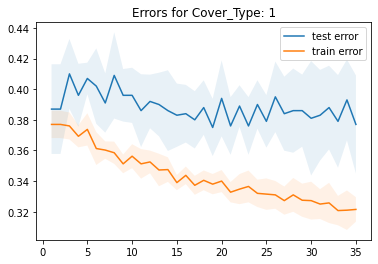

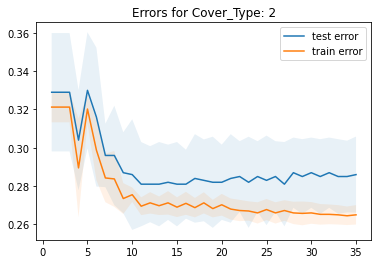

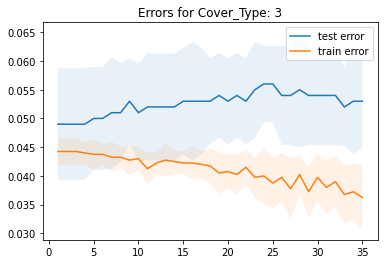

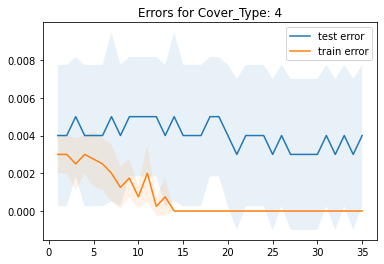

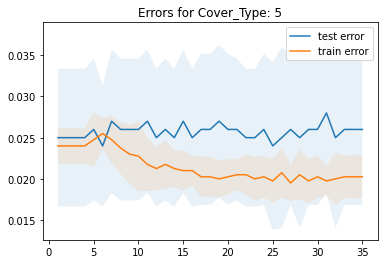

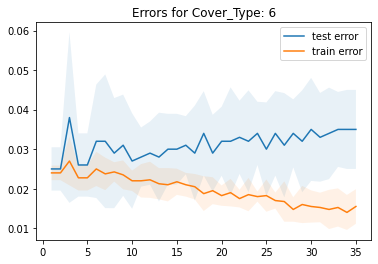

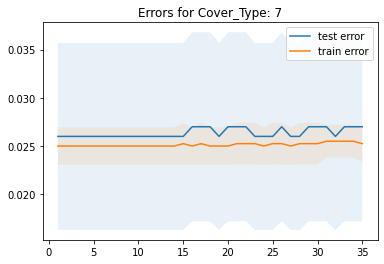

In [21]:
# plot of test and train errors of the one-vs-all classification at each round for every class.

for i in range(n_classes):

    fig, ax = plt.subplots()

    epochs = range(1, T+1)

    mean_test_error = np.mean(cv_test_classes[i], axis=0)
    std_test_error = np.std(cv_test_classes[i], axis=0)

    ax.plot(epochs, mean_test_error, label = "test error")
    ax.fill_between(epochs, mean_test_error-std_test_error, mean_test_error+std_test_error ,alpha=0.1)

    mean_train_error = np.mean(cv_train_classes[i], axis=0)
    std_train_error = np.std(cv_train_classes[i], axis=0)

    ax.plot(epochs, mean_train_error, label = "train error")
    ax.fill_between(epochs, mean_train_error-std_train_error, mean_train_error+std_train_error ,alpha=0.1)

    plt.title(f'Errors for Cover_Type: {i+1}')
    plt.legend()
    plt.show()

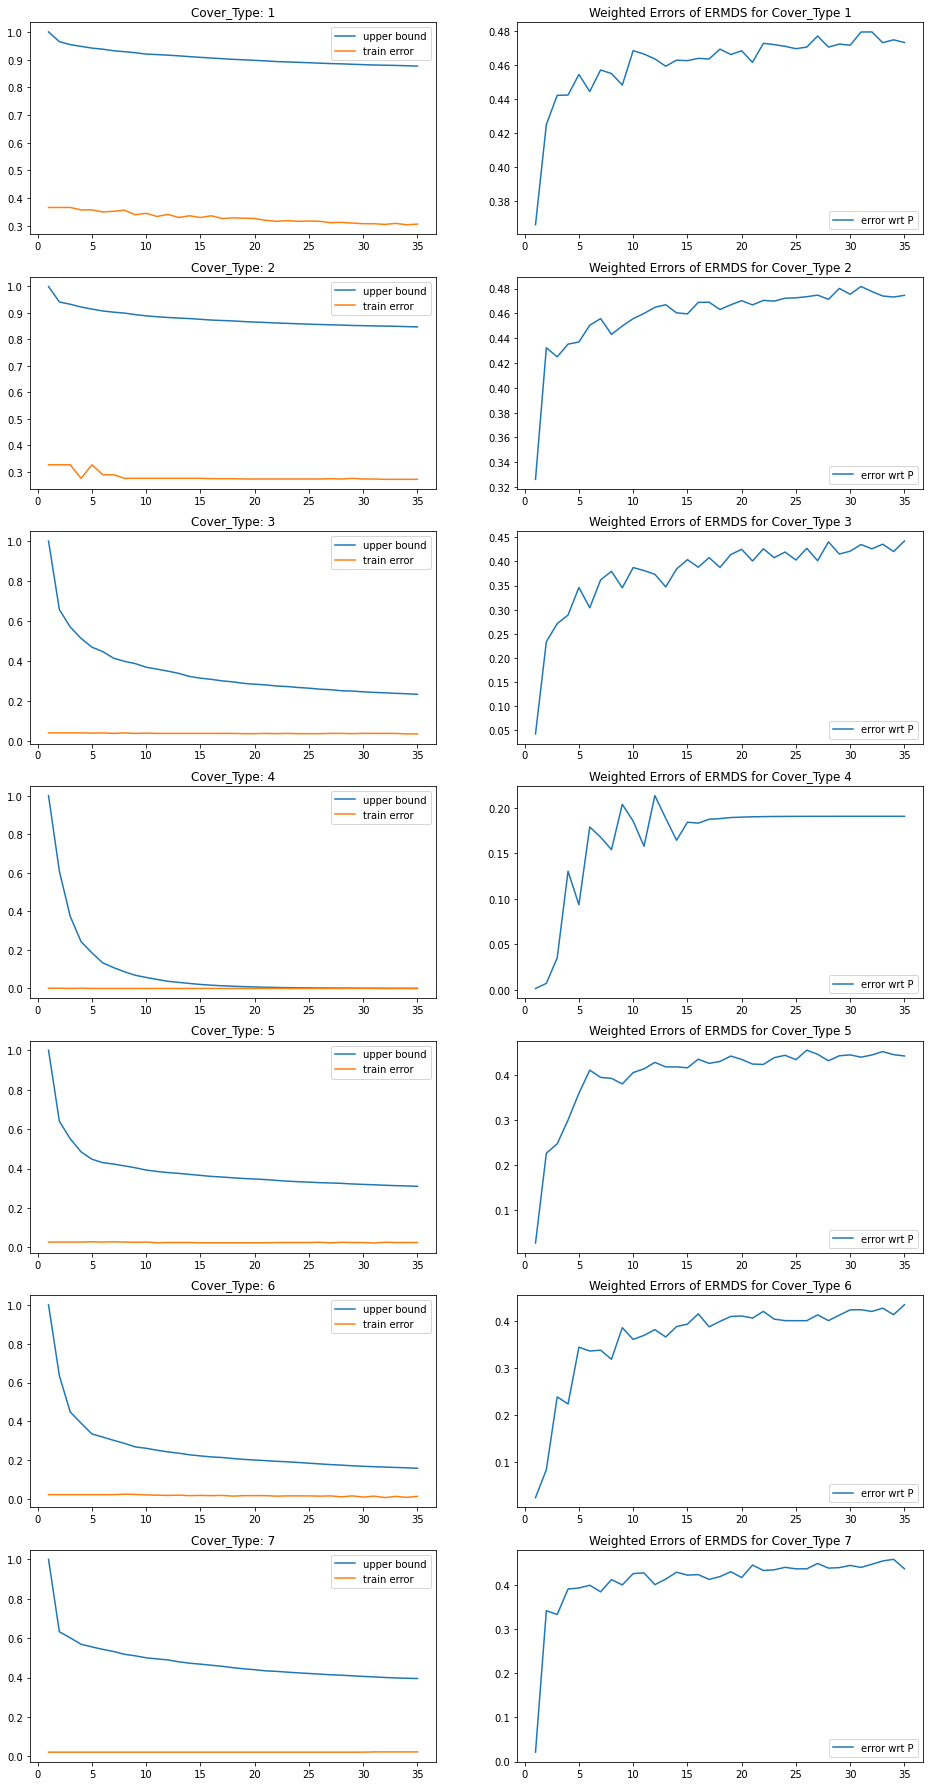

In [26]:
# plot of train errors of the one-vs-all classification at each round for every class,
# analysis wrt the theoretical upper bound and the weigths of the weak learners used.
# last fold

y = model.get_error_according_to_p_i()

fig, axs = plt.subplots(7, 2)
fig.set_size_inches(16, 32)

for i, errors in enumerate(y):

    gamma = np.ones(len(errors))*1/2 - errors

    upper_bound = [exp(-2*np.sum(np.power(gamma[:t],2))) for t in range(T)]

    axs[i, 0].plot(range(1, T+1), upper_bound, label = "upper bound")
    axs[i, 0].plot(range(1, T+1), cv_train_classes[i][K-1], label = "train error")
    axs[i, 0].legend(loc="upper right")
    axs[i, 0].set_title(f'Cover_Type: {i+1}')
    axs[i, 1].plot(range(1, T+1), errors, label = "error wrt P")
    axs[i, 1].set_title(f'Weighted Errors of ERMDS for Cover_Type {i+1}')
    axs[i, 1].legend(loc="lower right")

## Same experiment with a bigger sample set

*   K = 5
*   T = 20
*   N = 100000



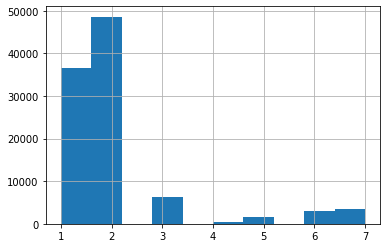

In [2]:
K = 5
k_fold = KFold(n_splits=K)
T = 20

n_classes = 7
model = MyAdaBoost(T, [1,2,3,4,5,6,7], save_statistics=True)

df = pd.read_csv('covtype.csv', sep=',',header=0)
df = df.sample(n=100000, random_state=5).reset_index(drop=True)

df.Cover_Type.hist()

cv_train_full = []
cv_train_classes = [[],[],[],[],[],[],[]]
cv_test_full = []
cv_test_classes = [[],[],[],[],[],[],[]]

In [3]:
# Cross Validation, taking values at each round for every fold.

for train, test in k_fold.split(df):
    
    start = time.time()
    model.fit(df.loc[train])
    print(f"fit in time {time.time()-start} / {(time.time()-start)/T} single round")

    start = time.time()
    errors_rounds = [model.error(df.loc[test], t, True) for t in range(1, T+1)]
    cv_test_full.append([full_error for full_error,_ in errors_rounds])

    for i in range(n_classes):
        cv_test_classes[i].append([class_error[i] for _,class_error in errors_rounds])
    
    errors_rounds = [model.error(df.loc[train], t, True) for t in range(1, T+1)]
    cv_train_full.append([full_error for full_error,_ in errors_rounds])

    for i in range(n_classes):
        cv_train_classes[i].append([class_error[i] for _,class_error in errors_rounds])

    print(f"computed errors in {time.time()-start}")

print(f"train\n{cv_train_full}\n" +
      f"test\n{cv_test_full}\n")

fit in time 1829.065712928772 / 91.45328986644745 single round
computed errors in 68.45979332923889
fit in time 1825.6308391094208 / 91.28154577016831 single round
computed errors in 68.53582572937012
fit in time 1822.469202041626 / 91.1234636425972 single round
computed errors in 68.79569387435913
fit in time 1817.6316950321198 / 90.88158873319625 single round
computed errors in 68.47488236427307
fit in time 1821.1072883605957 / 91.05536793470382 single round
computed errors in 68.8992235660553
train
[[0.3655375, 0.3655375, 0.3655375, 0.3384625, 0.37325, 0.3654625, 0.345025, 0.3383125, 0.343725, 0.3378375, 0.3433125, 0.337825, 0.3432875, 0.3433, 0.3432875, 0.3631, 0.344075, 0.344725, 0.3455125, 0.3464375], [0.3644, 0.3644, 0.3644, 0.3363125, 0.371275, 0.371275, 0.345875, 0.3431875, 0.3444875, 0.3422625, 0.3428125, 0.342375, 0.3428375, 0.34195, 0.3427875, 0.36095, 0.3435875, 0.345275, 0.3450375, 0.3485875], [0.3662125, 0.3662125, 0.3662125, 0.3369375, 0.3723125, 0.3743375, 0.3430125, 0

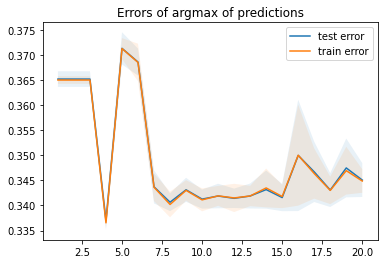

In [4]:
# plot of test and train errors on the multiclassification at each round.

fig, ax = plt.subplots()
  
epochs = range(1, T+1)

mean_test_error = np.mean(cv_test_full, axis=0)
std_test_error = np.std(cv_test_full, axis=0)

ax.plot(epochs, mean_test_error, label = "test error")
ax.fill_between(epochs, mean_test_error-std_test_error, mean_test_error+std_test_error ,alpha=0.1)

mean_train_error = np.mean(cv_train_full, axis=0)
std_train_error = np.std(cv_train_full, axis=0)

ax.plot(epochs, mean_train_error, label = "train error")
ax.fill_between(epochs, mean_train_error-std_train_error, mean_train_error+std_train_error ,alpha=0.1)

plt.title('Errors of argmax of predictions')
plt.legend()
plt.show()

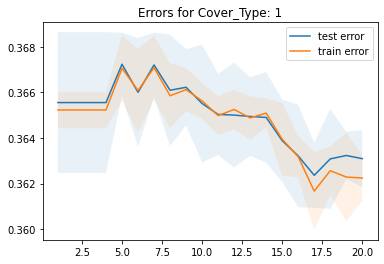

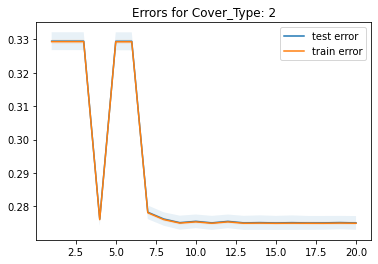

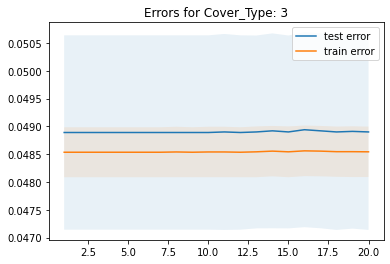

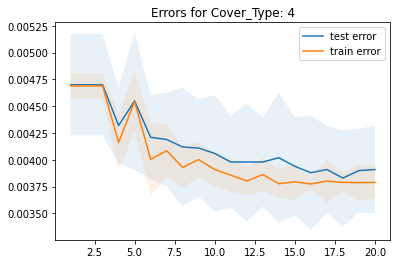

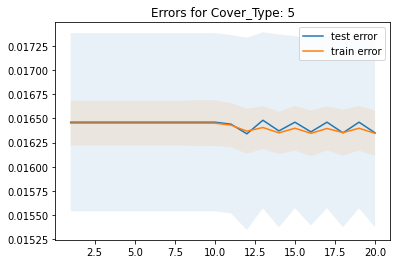

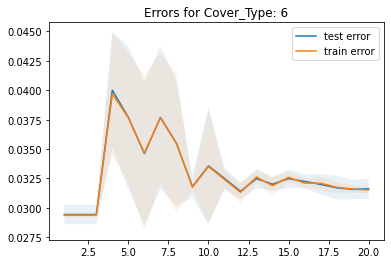

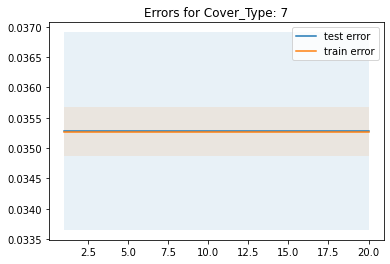

In [5]:
# plot of test and train errors of the one-vs-all classification at each round for every class.

for i in range(n_classes):

    fig, ax = plt.subplots()

    epochs = range(1, T+1)

    mean_test_error = np.mean(cv_test_classes[i], axis=0)
    std_test_error = np.std(cv_test_classes[i], axis=0)

    ax.plot(epochs, mean_test_error, label = "test error")
    ax.fill_between(epochs, mean_test_error-std_test_error, mean_test_error+std_test_error ,alpha=0.1)

    mean_train_error = np.mean(cv_train_classes[i], axis=0)
    std_train_error = np.std(cv_train_classes[i], axis=0)

    ax.plot(epochs, mean_train_error, label = "train error")
    ax.fill_between(epochs, mean_train_error-std_train_error, mean_train_error+std_train_error ,alpha=0.1)

    plt.title(f'Errors for Cover_Type: {i+1}')
    plt.legend()
    plt.show()

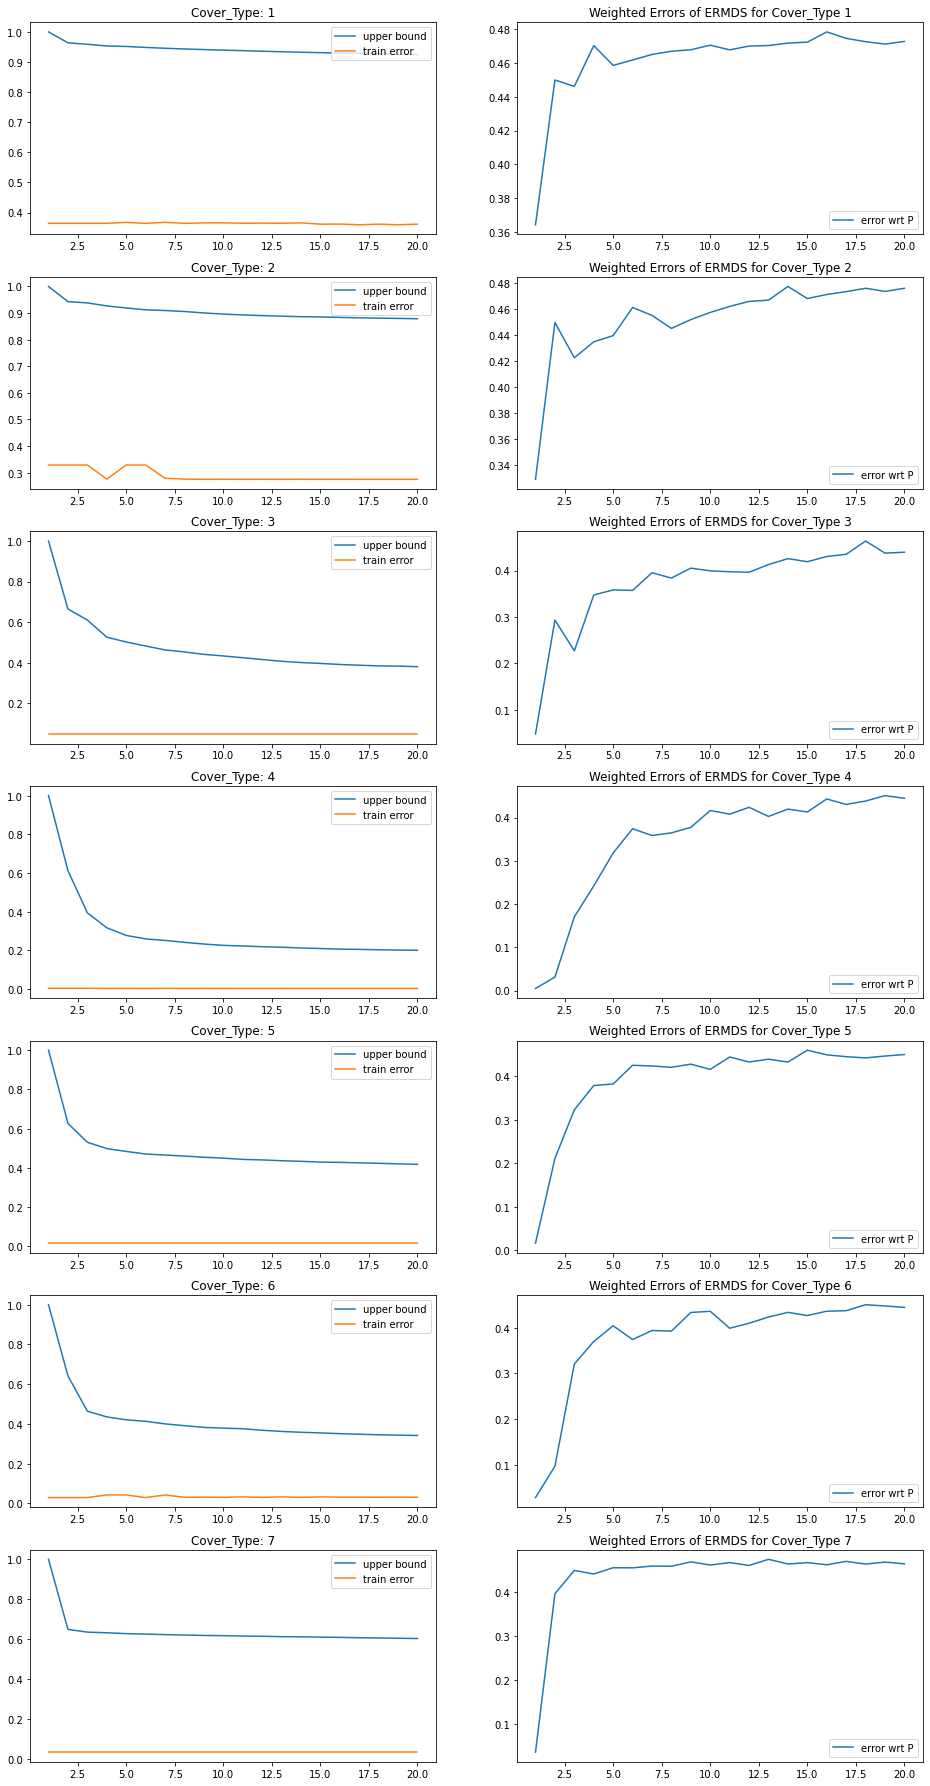

In [6]:
# plot of train errors of the one-vs-all classification at each round for every class,
# analysis wrt the theoretical upper bound and the weigths of the weak learners used.
# last fold.

y = model.get_error_according_to_p_i()

fig, axs = plt.subplots(7, 2)
fig.set_size_inches(16, 32)

for i, errors in enumerate(y):

    gamma = np.ones(len(errors))*1/2 - errors

    upper_bound = [exp(-2*np.sum(np.power(gamma[:t],2))) for t in range(T)]

    axs[i, 0].plot(range(1, T+1), upper_bound, label = "upper bound")
    axs[i, 0].plot(range(1, T+1), cv_train_classes[i][K-1], label = "train error")
    axs[i, 0].legend(loc="upper right")
    axs[i, 0].set_title(f'Cover_Type: {i+1}')
    axs[i, 1].plot(range(1, T+1), errors, label = "error wrt P")
    axs[i, 1].set_title(f'Weighted Errors of ERMDS for Cover_Type {i+1}')
    axs[i, 1].legend(loc="lower right")